# A Simple RNN

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

/home/ss/anaconda3/envs/pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow Version: 2.8.2
Pandas Version: 1.4.3
Numpy Version: 1.23.3
System Version: 3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]


In [2]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 1000
TRAIN_SPLIT = 20000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 4
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./data/train.csv')
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 29701 rows, 10 columns


,t,1,2,3,4,time,x,y,delta_x,delta_y
0,0.00,119.947865,102.751992,100.623908,101,0.00,15.860380,-23.297520,0.000000,0.000000
1,0.01,119.927054,102.738962,100.628316,101,0.01,15.860189,-23.298586,-0.000191,-0.001066
2,0.02,119.906244,102.725932,100.632724,101,0.02,15.859999,-23.299651,-0.000191,-0.001066
3,0.03,119.885434,102.712902,100.637131,101,0.03,15.859808,-23.300717,-0.000191,-0.001066
4,0.04,119.864623,102.699872,100.641539,101,0.04,15.859618,-23.301783,-0.000191,-0.001066


In [17]:
features_considered = ['1', '2', '3', 'x', 'y']

features = df[features_considered]
features.index = df['t']
features.head()

,1,2,3,x,y
t,,,,,
0.00,119.947865,102.751992,100.623908,15.860380,-23.297520
0.01,119.927054,102.738962,100.628316,15.860189,-23.298586
0.02,119.906244,102.725932,100.632724,15.859999,-23.299651
0.03,119.885434,102.712902,100.637131,15.859808,-23.300717
0.04,119.864623,102.699872,100.641539,15.859618,-23.301783


array([<AxesSubplot:xlabel='t'>, <AxesSubplot:xlabel='t'>,
       <AxesSubplot:xlabel='t'>, <AxesSubplot:xlabel='t'>,
       <AxesSubplot:xlabel='t'>], dtype=object)

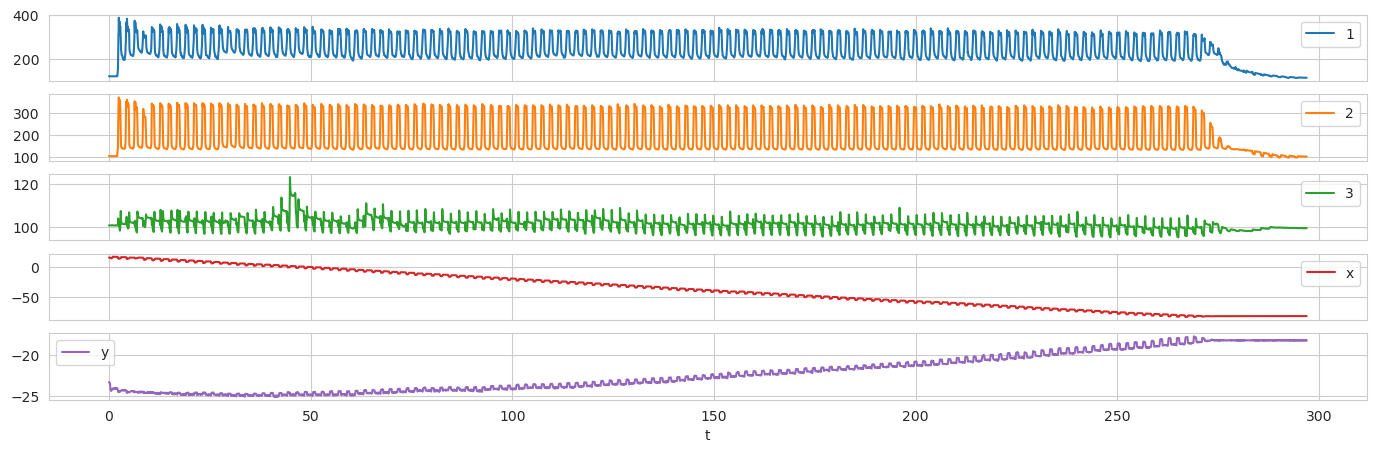

In [18]:
features.plot(subplots=True)

In [19]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset.shape)
display(pd.DataFrame(dataset, columns = features.columns, index= features.index).head())

(29701, 5)


,1,2,3,x,y
t,,,,,
0.00,-2.582486,-1.171419,-0.432380,1.629950,0.250894
0.01,-2.582878,-1.171570,-0.430709,1.629941,0.249977
0.02,-2.583270,-1.171721,-0.429039,1.629933,0.249060
0.03,-2.583663,-1.171872,-0.427368,1.629924,0.248143
0.04,-2.584055,-1.172023,-0.425697,1.629916,0.247227


In [20]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [21]:
past_history = 1000
future_target = 100
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [22]:
print(x_train_single.shape)
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(x_train_single.shape[-2:])

(19000, 167, 5)
Single window of past history : (167, 5)
(167, 5)


In [23]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [40]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(5))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
print(x_train_single.shape[-2:])
print(single_step_model.summary())

(167, 5)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32)                4864      
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 5,029
Trainable params: 5,029
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 5)


In [42]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
single_step_history = single_step_model.fit(train_data_single,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            callbacks=[early_stopping],
                                            validation_steps=50)

Evaluation Threshold: 200
Epochs: 4
Epoch 1/4
200/200 [==============================] - 36s 173ms/step - loss: 0.2531 - val_loss: 0.4432
Epoch 2/4
200/200 [==============================] - 34s 168ms/step - loss: 0.0848 - val_loss: 0.2204
Epoch 3/4
200/200 [==============================] - 32s 161ms/step - loss: 0.0606 - val_loss: 0.2193
Epoch 4/4
200/200 [==============================] - 33s 165ms/step - loss: 0.0545 - val_loss: 0.1862


In [43]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

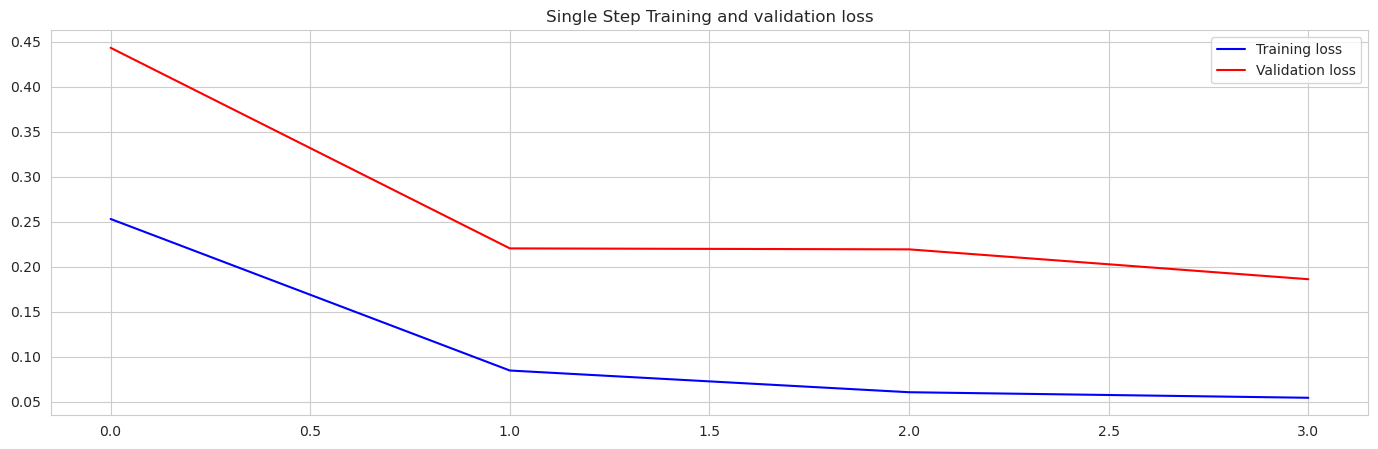

In [44]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

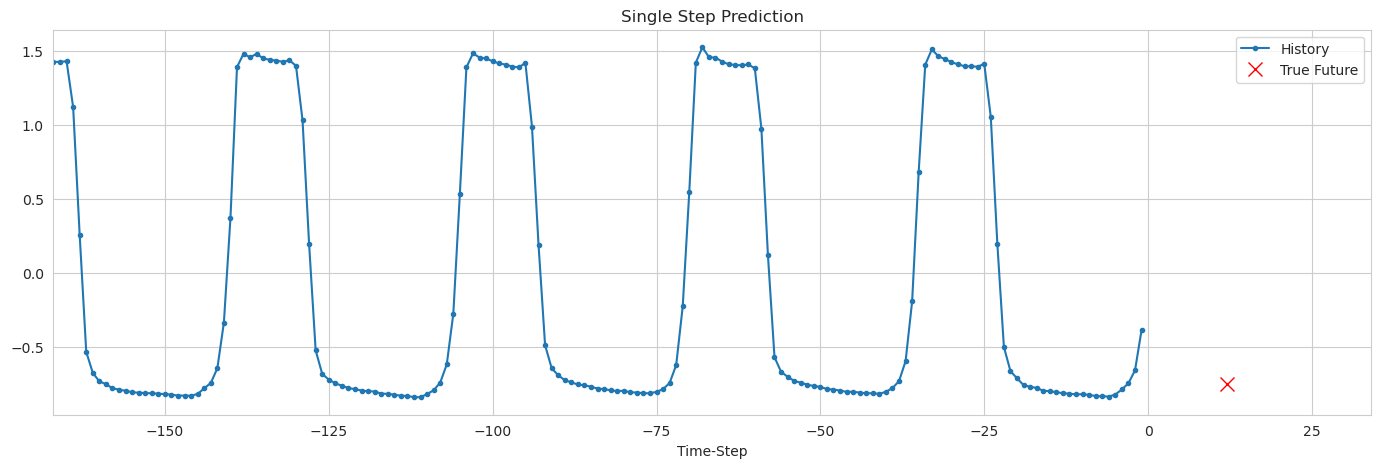

In [45]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

## Multi-step